In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('lending_club_loan_two.csv')

In [4]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [5]:
df = df.drop('emp_title',axis=1)

In [6]:
emp_co = df[df['loan_status']=='Charged Off'].groupby('emp_length').count()['loan_status']
emp_fp = df[df['loan_status']=='Fully Paid'].groupby('emp_length').count()['loan_status']

In [7]:
df = df.drop('emp_length',axis=1)

In [8]:
df = df.drop('title',axis=1)

In [9]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

# %%
# filling out missing values in mort_acc
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

# %%
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

/tmp/ipykernel_11136/1719564190.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_acc_avg = df.groupby('total_acc').mean()['mort_acc']


In [10]:
df = df.dropna()

In [11]:
dummies = pd.get_dummies(df[['verification_status','application_type','initial_list_status','purpose']],drop_first=True)
df = pd.concat([df.drop(['verification_status','application_type','initial_list_status','purpose'],axis=1),dummies],axis=1)

In [12]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')

# %%
dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = pd.concat([df.drop(['home_ownership'],axis=1),dummies],axis=1)

In [13]:
df['address'].apply(lambda address:address[-5:])

# %%
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

In [14]:
dummies = pd.get_dummies(df['zip_code'],drop_first=True)
df = pd.concat([df.drop(['zip_code'],axis=1),dummies],axis=1)

# %%
df = df.drop('address',axis=1)
df = df.drop('issue_d',axis=1)
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))
df = df.drop('grade',axis=1)
subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)

# %%
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

# %%
dummies = pd.get_dummies(df['term'],drop_first=True)
df = pd.concat([df.drop(['term'],axis=1),dummies],axis=1)

# %%
dummies = pd.get_dummies(df['loan_status'],drop_first=True)
df = pd.concat([df.drop(['loan_status'],axis=1),dummies],axis=1)

In [39]:
from sklearn.model_selection import train_test_split
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=101)

In [41]:
from sklearn.preprocessing import MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
X_train = scaler.fit_transform(X_train)

In [44]:
X_test = scaler.transform(X_test)

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [46]:
model = Sequential()

In [47]:
model.add(Dense(78,activation='relu')) # input layer
model.add(Dropout(0.2))
model.add(Dense(78,activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [48]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=750,
    epochs=25,
    validation_data=(X_test,y_test),
)

Epoch 1/25
422/422 [==============================] - 4s 7ms/step - loss: 0.0556 - accuracy: 0.9760 - val_loss: 4.7174e-06 - val_accuracy: 1.0000
Epoch 2/25
422/422 [==============================] - 4s 9ms/step - loss: 8.0691e-05 - accuracy: 1.0000 - val_loss: 5.1982e-07 - val_accuracy: 1.0000
Epoch 3/25
422/422 [==============================] - 4s 9ms/step - loss: 2.3385e-05 - accuracy: 1.0000 - val_loss: 1.4098e-07 - val_accuracy: 1.0000
Epoch 4/25
422/422 [==============================] - 3s 8ms/step - loss: 1.0992e-05 - accuracy: 1.0000 - val_loss: 6.0555e-08 - val_accuracy: 1.0000
Epoch 5/25
422/422 [==============================] - 3s 8ms/step - loss: 1.0119e-05 - accuracy: 1.0000 - val_loss: 2.8434e-08 - val_accuracy: 1.0000
Epoch 6/25
422/422 [==============================] - 4s 9ms/step - loss: 1.5801e-05 - accuracy: 1.0000 - val_loss: 2.0104e-08 - val_accuracy: 1.0000
Epoch 7/25
422/422 [==============================] - 4s 8ms/step - loss: 3.5393e-06 - accuracy: 1.0000 

In [49]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot: >

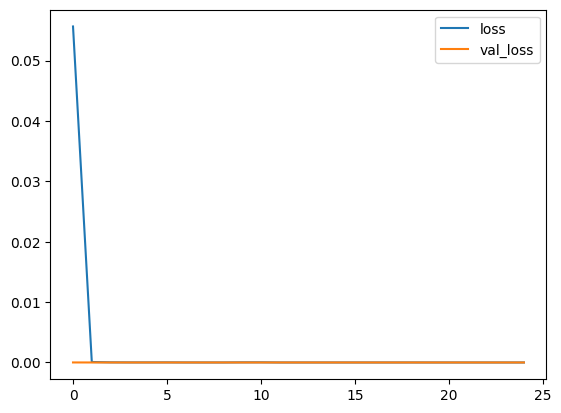

In [50]:
losses[['loss','val_loss']].plot()

In [51]:
from sklearn.metrics import classification_report,confusion_matrix

In [52]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

2471/2471 [==============================] - 3s 1ms/step


In [53]:
predict_x.round()

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [54]:
print(classification_report(y_test,predict_x))

ValueError: Classification metrics can't handle a mix of binary and continuous targets